In [53]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

In [54]:
data = '../data/MIT/'
original = img.imread(data + 'apple/original.png')
reflectance = img.imread(data + 'apple/reflectance.png')
shading = img.imread(data + 'apple/shading.png')
shading = np.stack([shading,shading,shading], axis=2)

In [97]:
data = '../data/Sintel/'
cleans = data + 'clean/'
albedos = data + 'albedo/'
frame = 'alley_1/frame_0001.png'

original = np.clip(img.imread(cleans + frame, format='RGB'), 1, 255) / 255
reflectance = np.clip(img.imread(albedos + frame, format='RGB'), 1, 255) / 255

shading = np.clip(original / reflectance, 0, 1)

In [95]:
# print(shading)

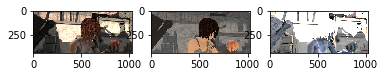

In [98]:
fig = plt.figure()
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(original)

a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(reflectance)

a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(shading)

/Users/aounleo/ProgrammingTools/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


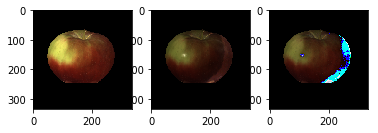

In [59]:
fig = plt.figure()
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(reflectance)

a=fig.add_subplot(1,3,2)
quotient = original / shading
imgplot = plt.imshow(quotient)

a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(reflectance - quotient)

/Users/aounleo/ProgrammingTools/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


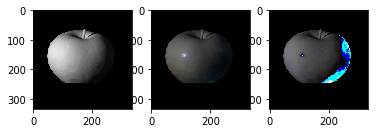

In [60]:
fig = plt.figure()
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(shading)

a=fig.add_subplot(1,3,2)
quotient = original / reflectance
imgplot = plt.imshow(quotient)

a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(shading - quotient)